In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn import tree

import pickle

In [2]:
df_permit_zone = pd.read_csv("./data/Parking_Permit_Zones.csv")
df_permit_zone.head()

,ROW ID,STATUS,ZONE,ODD_EVEN,ADDRESS RANGE - LOW,ADDRESS RANGE - HIGH,STREET DIRECTION,STREET NAME,STREET TYPE,SECOND STREET DIRECTION,BUFFER,WARD - LOW,WARD - HIGH
0,7485,ACTIVE,221,E,5900,5998,N,HARDING,AVE,NaN,N,NaN,NaN
1,7461,ACTIVE,382,E,4016,4046,S,KOMENSKY,AVE,NaN,N,NaN,NaN
2,7484,ACTIVE,221,O,5701,5799,N,HARDING,AVE,NaN,N,NaN,NaN
3,7483,ACTIVE,221,E,5700,5798,N,HARDING,AVE,NaN,N,NaN,NaN
4,7481,ACTIVE,221,E,5600,5698,N,HARDING,AVE,NaN,N,NaN,NaN


In [3]:
df_ticket = pd.read_csv("./data/Tickets_2007.csv")
df_ticket.head()

,Unnamed: 0,0,1,2,3,4,5
0,0,7000634986,2007-01-01 00:02:00,Y301669,PAS,IL,1900 N ASHLAND AVE
1,1,7000634946,2007-01-01 00:03:00,4703TX,TXI,IL,1600 W CORTLAND ST
2,2,7000634987,2007-01-01 00:14:00,9125630,PAS,IL,1900 N ASHLAND AVE
3,3,7000634926,2007-01-01 00:30:00,220H070,TMP,IL,2400 N KEDZIE AVE
4,4,7000635682,2007-01-01 00:43:00,4875778,PAS,IL,848 W 87TH STREET


In [4]:
df_traffic = pd.read_csv("./data/Average_Daily_Traffic_Counts.csv")
df_traffic.head()

,ID,Traffic Volume Count Location Address,Street,Date of Count,Total Passing Vehicle Volume,Vehicle Volume By Each Direction of Traffic,Latitude,Longitude,Location
0,414,5838 West,Lake St,11/14/2006,7100,East Bound: 3600 / West Bound: 3500,41.887904,-87.771064,"(41.887904, -87.771064)"
1,176,320 East,76th St,03/28/2006,8600,East Bound: 3800 / West Bound: 4800,41.756542,-87.617335,"(41.756542, -87.617335)"
2,1367,1730 East,57th Dr,08/24/2006,53500,East Bound: 27800 / West Bound: 25700,41.792663,-87.582231,"(41.792663, -87.582231)"
3,316,125 East,24th St,03/30/2006,700,East Bound: 400 / West Bound: 300,41.849302,-87.622658,"(41.849302, -87.622658)"
4,1294,2924 East,130th St,08/29/2006,4200,East Bound: 2300 / West Bound: 1900,41.659177,-87.552112,"(41.659177, -87.552112)"


In [5]:
#df_building = pd.read_csv("./data/Vacant_Buildings.csv")
#df_building.head()

In [6]:
# Permit Zone Clean
df_permit_zone["Street"] = df_permit_zone.apply(lambda row: \
                                                str(row["STREET NAME"]).lower().capitalize() + \
                                                " " + str(row["STREET TYPE"]).lower().capitalize() \
                                                , axis=1)
df_permit_zone = df_permit_zone.groupby("Street").count()["ROW ID"].reset_index()
df_permit_zone = df_permit_zone.rename(columns={"ROW ID": "Permits"})
df_permit_zone.head()

,Street,Permits
0,100th Pl,4
1,100th St,3
2,101st Pl,2
3,101st St,6
4,102nd Pl,2


In [7]:
# Ticket Clean
df_ticket = df_ticket.drop(["Unnamed: 0", "0", "2", "3", "4"], axis=1)
df_ticket = df_ticket.rename(columns={"1": "Time", '5': "Address"})
df_ticket["Time"] = pd.to_datetime(df_ticket["Time"])
df_ticket["Year"] = df_ticket["Time"].dt.year
df_ticket["Date"] = df_ticket["Time"].dt.strftime('%m-%d')
df_ticket = df_ticket[["Date", "Address"]]
df_ticket.head()

,Date,Address
0,01-01,1900 N ASHLAND AVE
1,01-01,1600 W CORTLAND ST
2,01-01,1900 N ASHLAND AVE
3,01-01,2400 N KEDZIE AVE
4,01-01,848 W 87TH STREET


In [8]:
df_ticket["Street"] = df_ticket["Address"].apply(lambda x: \
                                                 " ".join([y.lower().capitalize()\
                                                           .replace("Street", "St")\
                                                           .replace("Road", "Rd")\
                                                           .replace("Boulevard", "Blvd")\
                                                           .replace("Avenue", "Ave") \
                                                           for y in x.split(" ")[-2:]]))
df_ticket = df_ticket.drop(["Address"], axis=1)
df_ticket.head()

,Date,Street
0,01-01,Ashland Ave
1,01-01,Cortland St
2,01-01,Ashland Ave
3,01-01,Kedzie Ave
4,01-01,87th St


In [9]:
# Ticket Clean
df_ticket_cleaned = pd.DataFrame(df_ticket.groupby(["Date", "Street"]).size().reset_index())
df_ticket_cleaned = df_ticket_cleaned.rename(columns={0: "Tickets"})
df_ticket_cleaned.head()

,Date,Street,Tickets
0,01-01,103rd St,3
1,01-01,111th St,9
2,01-01,115th St,2
3,01-01,119th St,9
4,01-01,31st St,6


In [10]:
# Traffic Clean
df_traffic["Date of Count"] = pd.to_datetime(df_traffic["Date of Count"])
df_traffic["Date"] = df_traffic["Date of Count"].dt.strftime('%m-%d')
df_traffic = df_traffic.drop(["Date of Count", "ID ", \
                              "Traffic Volume Count Location  Address", \
                              "Vehicle Volume By Each Direction of Traffic"], \
                             axis=1)
df_traffic = df_traffic.rename(columns={"Total Passing Vehicle Volume": "Traffic"})
df_traffic.head()

,Street,Traffic,Latitude,Longitude,Location,Date
0,Lake St,7100,41.887904,-87.771064,"(41.887904, -87.771064)",11-14
1,76th St,8600,41.756542,-87.617335,"(41.756542, -87.617335)",03-28
2,57th Dr,53500,41.792663,-87.582231,"(41.792663, -87.582231)",08-24
3,24th St,700,41.849302,-87.622658,"(41.849302, -87.622658)",03-30
4,130th St,4200,41.659177,-87.552112,"(41.659177, -87.552112)",08-29


In [11]:
# Join DF
df = pd.merge(df_traffic, df_ticket_cleaned,how="left", left_on=["Date","Street"], right_on=["Date","Street"])
df = pd.merge(df, df_permit_zone, how="left", left_on=["Street"], right_on=["Street"])
df.head()

,Street,Traffic,Latitude,Longitude,Location,Date,Tickets,Permits
0,Lake St,7100,41.887904,-87.771064,"(41.887904, -87.771064)",11-14,NaN,1.0
1,76th St,8600,41.756542,-87.617335,"(41.756542, -87.617335)",03-28,NaN,1.0
2,57th Dr,53500,41.792663,-87.582231,"(41.792663, -87.582231)",08-24,NaN,NaN
3,24th St,700,41.849302,-87.622658,"(41.849302, -87.622658)",03-30,NaN,14.0
4,130th St,4200,41.659177,-87.552112,"(41.659177, -87.552112)",08-29,NaN,NaN


In [12]:
# Train Data
df_train = df.dropna()
df_train["Month"] = df_train.apply(lambda x: x["Date"][:2], axis=1)
df_train["Day"] = df_train.apply(lambda x: x["Date"][-2:], axis=1)
df_train["Parking Condition"] = df_train.apply(lambda x: int(x["Permits"] > x["Tickets"]), axis=1)
df_train

,Street,Traffic,Latitude,Longitude,Location,Date,Tickets,Permits,Month,Day,Parking Condition
6,Kimball Ave,15600,41.992042,-87.714036,"(41.992042, -87.714036)",08-15,7.0,4.0,08,15,0
7,Ashland Ave,26700,41.974889,-87.669587,"(41.974889, -87.669587)",08-22,79.0,22.0,08,22,0
8,State St,19300,41.777072,-87.625260,"(41.777072, -87.62526)",05-02,15.0,23.0,05,02,1
10,Diversey Ave,16600,41.930851,-87.797915,"(41.930851, -87.797915)",08-16,15.0,13.0,08,16,0
11,Ashland Ave,33400,41.955361,-87.669076,"(41.955361, -87.669076)",08-29,106.0,22.0,08,29,0
...,...,...,...,...,...,...,...,...,...,...,...
1271,State St,21100,41.896924,-87.628206,"(41.896924, -87.628206)",09-21,43.0,23.0,09,21,0
1273,Pulaski Rd,29500,41.836244,-87.724337,"(41.836244, -87.724337)",09-14,88.0,20.0,09,14,0
1275,Pulaski Rd,21300,41.918169,-87.726590,"(41.918169, -87.72659)",10-05,85.0,20.0,10,05,0
1276,Halsted St,13200,41.784530,-87.644905,"(41.78453, -87.644905)",03-21,50.0,68.0,03,21,1


In [13]:
# Test Data
df_test = df.dropna(subset=["Permits"])
df_test = df_test[df_test['Tickets'].isna()]
df_test["Month"] = df_test.apply(lambda x: x["Date"][:2], axis=1)
df_test["Day"] = df_test.apply(lambda x: x["Date"][-2:], axis=1)
df_test

,Street,Traffic,Latitude,Longitude,Location,Date,Tickets,Permits,Month,Day
0,Lake St,7100,41.887904,-87.771064,"(41.887904, -87.771064)",11-14,NaN,1.0,11,14
1,76th St,8600,41.756542,-87.617335,"(41.756542, -87.617335)",03-28,NaN,1.0,03,28
3,24th St,700,41.849302,-87.622658,"(41.849302, -87.622658)",03-30,NaN,14.0,03,30
5,Lake St,6900,41.885023,-87.675556,"(41.885023, -87.675556)",10-19,NaN,1.0,10,19
20,71st St,15600,41.764348,-87.704780,"(41.764348, -87.70478)",11-14,NaN,4.0,11,14
...,...,...,...,...,...,...,...,...,...,...
1265,Homan Ave,2000,41.838150,-87.709739,"(41.83815, -87.709739)",09-14,NaN,14.0,09,14
1267,18th St,3800,41.857890,-87.622993,"(41.85789, -87.622993)",04-25,NaN,10.0,04,25
1268,Sheffield Ave,10700,41.933448,-87.653886,"(41.933448, -87.653886)",10-04,NaN,31.0,10,04
1272,Torrence Ave,15100,41.655545,-87.559298,"(41.655545, -87.559298)",11-08,NaN,2.0,11,08


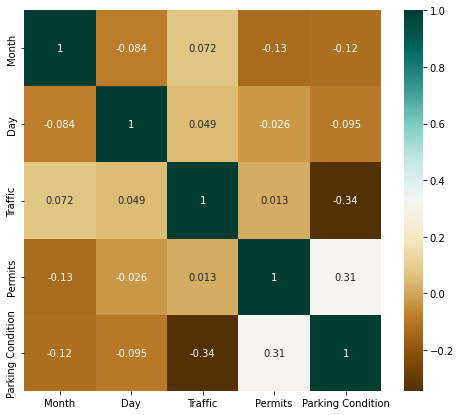

In [14]:
# Visual
plt.figure(figsize=(8,7))
g = sns.heatmap(df_train[["Month","Day","Traffic","Permits","Parking Condition"]].astype(int).corr(),\
                    cmap="BrBG",annot=True)

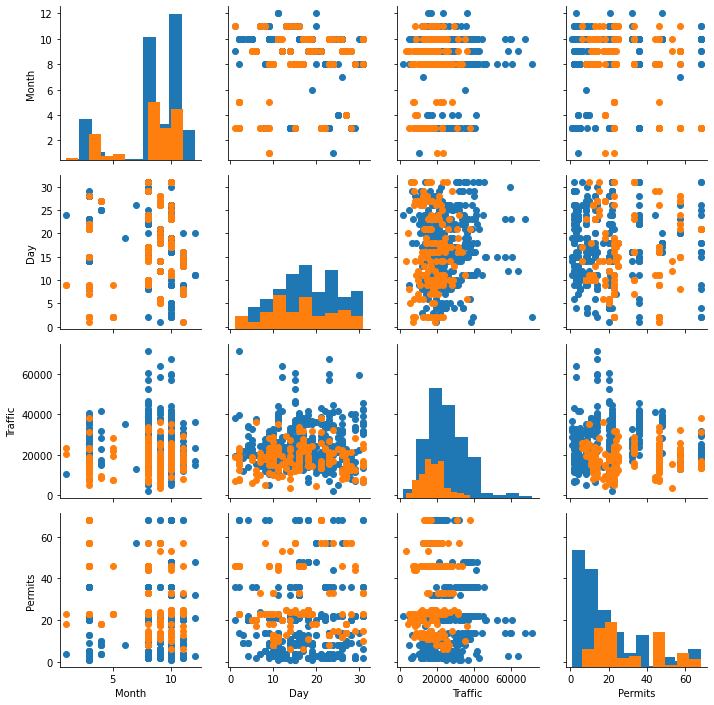

In [15]:
subset = ["Month","Day","Traffic","Permits","Parking Condition"]
columns = ["Month","Day","Traffic","Permits"]
ax = sns.PairGrid(df_train[subset].astype(int), vars = columns, hue = 'Parking Condition')
ax = ax.map_diag(plt.hist)
ax = ax.map_offdiag(plt.scatter)

In [16]:
# Prepare X and y
X = df_train[["Month","Day","Traffic","Permits"]].values.astype(int)
y = np.array(df_train["Parking Condition"])

In [17]:
X_test = df_test[["Month","Day","Traffic","Permits"]].values.astype(int)

In [18]:
# Standardlize
X = StandardScaler().fit_transform(X)
X_test = StandardScaler().fit_transform(X_test)

In [19]:
# Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Train and Validate
random_state = 42

classifiers = []

classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_valid, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_valid, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_valid, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_valid, y_pred)
    
    row += 1

In [21]:
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score
0,LogisticRegression,0.749607,0.683768,0.409357,0.505553,0.782609,0.730769,0.513514,0.603175
1,KNeighborsClassifier,0.877405,0.831574,0.778655,0.797463,0.852174,0.763158,0.783784,0.773333
2,DecisionTreeClassifier,0.873956,0.81183,0.790351,0.798618,0.886957,0.833333,0.810811,0.821918
3,RandomForestClassifier,0.921204,0.889081,0.861988,0.874282,0.921739,0.911765,0.837838,0.873239
4,AdaBoostClassifier,0.856352,0.792666,0.756433,0.769835,0.869565,0.823529,0.756757,0.788732
5,GradientBoostingClassifier,0.921234,0.884982,0.867544,0.875365,0.947826,0.897436,0.945946,0.921053
6,ExtraTreesClassifier,0.933454,0.92518,0.861696,0.890384,0.93913,0.916667,0.891892,0.90411
7,BaggingClassifier,0.896673,0.870686,0.795322,0.828256,0.886957,0.833333,0.810811,0.821918
8,SVC,0.830188,0.776761,0.657602,0.708602,0.834783,0.725,0.783784,0.753247
9,GaussianNB,0.738959,0.644087,0.425146,0.50747,0.817391,0.75,0.648649,0.695652


In [22]:
#text_representation = tree.export_text(classifiers[2])
#print(text_representation)

In [23]:
#fig = plt.figure(figsize=(40,30))
#_ = tree.plot_tree(classifiers[2],
#                   filled=True)

In [24]:
# Test
df_test["Parking Condition"] = classifiers[5].predict(X_test)
df_test

,Street,Traffic,Latitude,Longitude,Location,Date,Tickets,Permits,Month,Day,Parking Condition
0,Lake St,7100,41.887904,-87.771064,"(41.887904, -87.771064)",11-14,NaN,1.0,11,14,0
1,76th St,8600,41.756542,-87.617335,"(41.756542, -87.617335)",03-28,NaN,1.0,03,28,0
3,24th St,700,41.849302,-87.622658,"(41.849302, -87.622658)",03-30,NaN,14.0,03,30,1
5,Lake St,6900,41.885023,-87.675556,"(41.885023, -87.675556)",10-19,NaN,1.0,10,19,0
20,71st St,15600,41.764348,-87.704780,"(41.764348, -87.70478)",11-14,NaN,4.0,11,14,0
...,...,...,...,...,...,...,...,...,...,...,...
1265,Homan Ave,2000,41.838150,-87.709739,"(41.83815, -87.709739)",09-14,NaN,14.0,09,14,1
1267,18th St,3800,41.857890,-87.622993,"(41.85789, -87.622993)",04-25,NaN,10.0,04,25,1
1268,Sheffield Ave,10700,41.933448,-87.653886,"(41.933448, -87.653886)",10-04,NaN,31.0,10,04,0
1272,Torrence Ave,15100,41.655545,-87.559298,"(41.655545, -87.559298)",11-08,NaN,2.0,11,08,0


In [25]:
# Predict Tickets
X = df_train[["Month","Day","Traffic","Permits"]].values.astype(int)
y = np.array(df_train["Tickets"])

X = StandardScaler().fit_transform(X)

lm = LinearRegression()
model = lm.fit(X, y)

df_test["Tickets"] = lm.predict(X_test)
df_test

,Street,Traffic,Latitude,Longitude,Location,Date,Tickets,Permits,Month,Day,Parking Condition
0,Lake St,7100,41.887904,-87.771064,"(41.887904, -87.771064)",11-14,10.952336,1.0,11,14,0
1,76th St,8600,41.756542,-87.617335,"(41.756542, -87.617335)",03-28,36.063781,1.0,03,28,0
3,24th St,700,41.849302,-87.622658,"(41.849302, -87.622658)",03-30,21.336041,14.0,03,30,1
5,Lake St,6900,41.885023,-87.675556,"(41.885023, -87.675556)",10-19,12.127870,1.0,10,19,0
20,71st St,15600,41.764348,-87.704780,"(41.764348, -87.70478)",11-14,41.834436,4.0,11,14,0
...,...,...,...,...,...,...,...,...,...,...,...
1265,Homan Ave,2000,41.838150,-87.709739,"(41.83815, -87.709739)",09-14,11.683823,14.0,09,14,1
1267,18th St,3800,41.857890,-87.622993,"(41.85789, -87.622993)",04-25,26.117149,10.0,04,25,1
1268,Sheffield Ave,10700,41.933448,-87.653886,"(41.933448, -87.653886)",10-04,55.199703,31.0,10,04,0
1272,Torrence Ave,15100,41.655545,-87.559298,"(41.655545, -87.559298)",11-08,39.611237,2.0,11,08,0


In [26]:
# Analysis
print("Good Parking Condition Percentage: " + \
      str(df_test[df_test["Parking Condition"]==1].shape[0] / df_test.shape[0] * 100) + "%")
print("Bad Parking Condition Percentage: " + \
      str(df_test[df_test["Parking Condition"]==0].shape[0] / df_test.shape[0] * 100) + "%")

Good Parking Condition Percentage: 34.78260869565217%
Bad Parking Condition Percentage: 65.21739130434783%


In [28]:
# Output
df_test.to_csv("./data/Data_Predicted.csv", index=False)